In [102]:
import pickle
import nltk
from glob import glob
from gensim.models import KeyedVectors
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.vocab as vocab
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import seaborn as sn

In [2]:
gensim_model = KeyedVectors.load_word2vec_format('models/1200_1507.txt')
model_vocab = gensim_model.wv.vocab

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [163]:
a = {1:2,3:4}
print(len(a))

2


In [185]:
class vocabulary():
    
    def __init__(self,model_vocab):
        self.word2idx = {word:model_vocab[word].index+1 for word in list(model_vocab)}
        self.pad_token = 0
        self.word2idx['<padtoken>'] = self.pad_token
        self.idx2word = {value:key for key,value in self.word2idx.items()}
        self.unkid = len(self.word2idx)
        
    def __len__(self):
        return len(self.word2idx)

    def __getitem__(self, word):
        return self.word2idx.get(word, self.unkid)

    def __contains__(self, word):
        return word in self.word2idx
    
    def id2word(self, wid):
        return self.idx2word[wid]
    
    def words2indices(self, sents):
        if type(sents[0]) == list:
            return [[self[w] for w in s] for s in sents]
        else:
            return [self[w] for w in sents]

    def indices2words(self, word_ids):
        return [self.idx2word[w_id] for w_id in word_ids]

    def pad_sents(self,sents, pad_token):
        sents_padded = []
        sents_lens = [len(sentence) for sentence in sents]
        max_sent_len = max(sents_lens)
        for sentence in sents:
            sents_padded.append(sentence)
            for _ in range(max_sent_len-len(sentence)):
                sents_padded[-1].append(pad_token)
        return sents_padded
    
    def add_words(self,word_list):
        for word in word_list:
            if self[word]==self.unkid:
                current_idx = self.unkid
                self.unkid = self.unkid+1
                self.word2idx[word]=current_idx
                self.idx2word[current_idx]=word
    
    def to_input_tensor(self,sents,device=torch.device('cuda:0')):
#         word_ids = self.words2indices(sents)
        word_ids = sents
        sents_t = self.pad_sents(word_ids, self['<padtoken>'])
        sents_var = torch.tensor(sents_t, dtype=torch.long, device=device)
        return torch.t(sents_var)

In [201]:
trial_vocab = vocabulary(model_vocab)

In [202]:
len_b4 = len(trial_vocab)
len_b4

35999

In [4]:
all_comps = pd.read_csv('Reports_2008.csv')

In [5]:
all_comps.head()

,cik,Tables,Images,Text
0,1000180,165.0,1.0,10-K 1 f38194e10vk.htm FORM 10-K e10vk Washin...
1,1000697,128.0,1.0,10-K 1 b68112wce10vk.htm WATERS CORPORATION e...
2,1001250,77.0,0.0,10-K 1 a08-22004_110k.htm 10-K Table of Conten...
3,1001288,184.0,1.0,"10-K 1 l29751ae10vk.htm LEXMARK INTERNATIONAL,..."
4,1002047,142.0,1.0,10-K 1 f38790e10vk.htm FORM 10-K e10vk Washin...


In [162]:
all_words = []
for i in range(len(all_comps)):
    current_words = nltk.tokenize.word_tokenize(all_comps.loc[i,'Text'])
    all_words.extend(current_words)
    all_words = list(set(all_words))
len(all_words)

128102

In [203]:
trial_vocab.add_words(all_words)
len(trial_vocab)

155863

In [125]:
class text_dataset(Dataset):
    
    def __init__(self,full_vocab,cluster_dict,embedding_dim=300,dataset_type='train',text_path=None,extracted_text=None):
        super(text_dataset,self).__init__()
        self.vocabulary = full_vocab
        # current implementation requires padtoken to be 0
        self.cluster_dict = cluster_dict
        self.text_path = text_path
        self.dataset_type = dataset_type
        self.extracted_text = extracted_text
        self.prepare_data()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        return self.X[idx],self.Y[idx]
    
    def prepare_data(self):
        random.seed(20)
        all_sentences = self.get_text(self.extracted_text)
        random.shuffle(all_sentences)
        train_len = int(0.8*len(all_sentences))
        if [] in all_sentences:
            raise ValueError('found empty list in all_sentences')
        if self.dataset_type == 'train':
            self.X = self.vocabulary.words2indices(all_sentences[:train_len])
            self.Y = self.get_clusters(all_sentences[:train_len])
        elif self.dataset_type == 'val':
            self.X = self.vocabulary.words2indices(all_sentences[train_len:])
            self.Y = self.get_clusters(all_sentences[train_len:])
        else :
            self.X = self.vocabulary.words2indices(all_sentences)
            self.Y = self.get_clusters(all_sentences)
            
    def word_count(self):
        count=0
        for x in self.X:
            count+=len(x)
        return count
    
    def get_clusters(self,sentences):
        cluster_ids = []
        for i in range(len(sentences)):
            cluster_ids.append([])
        for i,sentence in enumerate(sentences):
            for word in sentence:
                cluster_ids[i].append(self.get_cluster_idx(word))
        return cluster_ids
        
    def get_cluster_idx(self,key):
        for cluster_idx,cluster in self.cluster_dict.items():
            assert cluster_idx<29,'Cluster idx is problematic'
            if key in cluster:
                return cluster_idx
        return 0
        
    def get_text(self,extracted_text):
        text = []
        if self.text_path is not None:
            files = glob(f'{self.text_path}/*.txt')
            for file in files:
                with open(file) as f:
                    raw_text = list(filter(None, f.read().split('\n')))
                    f.close()
                int_text = [[x.casefold() for x in line.strip().split(' ') if x.isalpha()] for line in raw_text if len(line.strip().split(' '))>3]
                int_text = list(filter(lambda a: a != [], int_text))
                text.extend(int_text)
        if self.extracted_text is not None:
            raw_text = list(filter(None, self.extracted_text.split('.')))
            int_text = [[x.casefold() for x in line.strip().split(' ') if x.isalpha()] for line in raw_text if len(line.strip().split(' '))>3]
            int_text = list(filter(lambda a: a != [], int_text))
            text.extend(int_text)
        return text    

In [18]:
clustering_file = open('filtered_dict','rb')
cluster_dict = pickle.load(clustering_file)

In [204]:
class LSTM_model(nn.Module):
    
    def __init__(self,embedding_dim,hidden_dim,gensim_model,vocabulary,num_clusters,len_b4):
        super(LSTM_model,self).__init__()
        self.gensim_model = gensim_model
        self.embedding_dim = embedding_dim
        self.vocabulary = vocabulary
        self.device = torch.device('cpu')
        self.embedding_layer = nn.Embedding(len(self.vocabulary)+1,embedding_dim,padding_idx=self.vocabulary.pad_token)
        self.len_b4 = len_b4
        self.reset_vocab_weights(len_b4)
        self.encoder = nn.LSTM(input_size=embedding_dim,hidden_size=hidden_dim,bias=True,bidirectional=True)
        self.ffn = nn.Sequential(
            nn.Linear(2*hidden_dim,2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim,2*hidden_dim),
            nn.ReLU(),
            nn.Linear(2*hidden_dim,num_clusters)
        )
        
    def forward(self,X_padded,sentence_lens):
        # takes tokenised sentences as input, (n,s)
        X = self.embedding_layer(X_padded.t()).permute(1,0,2)
        packed_X = pack_padded_sequence(X,sentence_lens,enforce_sorted=False)
        # encoder takes (s,n,e) inputs
        packed_enc_hiddens, _ = self.encoder(packed_X)
        enc_hiddens = pad_packed_sequence(packed_enc_hiddens)[0].permute(1,0,2)
        out = self.ffn(enc_hiddens).permute(0,2,1)
        # permute to (n,c,d1) since loss is 2d
        return out
        
    def collate_fn(self,batch):
#         print('collate function')
#         print(type(batch))
#         print(batch)
        sentence_lens = [len(sample[0]) for sample in batch]
        sentences_X = [sample[0] for sample in batch]
        sentences_Y = [sample[1] for sample in batch]
#         print(sentences_X)
        X_padded = self.vocabulary.to_input_tensor(sentences_X,device=self.device)
        targets = torch.tensor(self.vocabulary.pad_sents(sents=sentences_Y,pad_token=0),dtype=torch.long)
        return X_padded,targets,sentence_lens
        
    def reset_vocab_weights(self,len_b4,sanity_check=True):
        # pad token MUST BE 0
        og_state = self.embedding_layer.weight.requires_grad
        self.embedding_layer.weight.requires_grad = False
        self.embedding_layer.weight[0,:] = torch.zeros((self.embedding_dim))
        self.embedding_layer.weight[1:len_b4,:] = torch.from_numpy(self.gensim_model.vectors)
        self.embedding_layer.weight.requires_grad = og_state
        if sanity_check:
            embedding_sanity_check = True
            for key,val in self.vocabulary.idx2word.items():
                if (key>0) and (key<len_b4) and (torch.sum((self.embedding_layer.weight[key,:]-torch.from_numpy(gensim_model[val])).pow(2))>1e-8):
                    embedding_sanity_check = False
            assert embedding_sanity_check, 'Word vectors of embeddings and gensim model do not match!'
        
    def set_embedding_layer_grad(self,state):
        self.embedding_layer.weight.requires_grad = state

In [205]:
model = LSTM_model(300,100,gensim_model,trial_vocab,num_clusters=29,len_b4=len_b4).to(device)

In [208]:
model.embedding_layer.weight.requires_grad

True

In [20]:
def fit(device,dataloaders,model,criterion,optimizer,scheduler=None,tb_logs=None,epochs=1):
        '''
        :param tb_logs: a dictionary containing tensorboard log flag, path and comment
        :param epochs:
        :return:
        '''
        if tb_logs is not None:
            logpath = tb_logs['path']
            logcomment = tb_logs['comment']
            tb = SummaryWriter(log_dir=logpath+f'/{logcomment}', comment=logcomment)
        best_model_wts = copy.deepcopy(model.state_dict())
        best_valid_loss=100.
        for epoch in range(epochs):
            print(f'EPOCH : {epoch + 1}/{epochs}')
            for phase in dataloaders.keys():
                since = time.time()
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                running_loss = 0.
                running_acc = 0.
                running_size = 0
                for inputs,targets,sentence_lens in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
                    with torch.set_grad_enabled(phase=='train'):
                        optimizer.zero_grad()
                        outputs = model(inputs,sentence_lens)
#                         print(outputs)
                        preds = torch.argmax(outputs,dim=1)
                        loss = criterion(outputs, targets)
                        acc = torch.mean((targets==preds).to(float)).item()
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        running_size += outputs.size()[0]*outputs.size()[2]
                        running_loss += loss.item() * inputs.size()[0]*inputs.size()[1]
                        running_acc += acc*inputs.size()[0]*inputs.size()[1]
                #                 if phase == 'train' and not(scheduler is None):
                #                     scheduler.step(epoch_loss)
                epoch_loss = running_loss/running_size
                epoch_acc = running_acc/running_size
                if tb_logs is not None:
                    if phase == 'train':
                        tb.add_scalar('Train Loss', epoch_loss, epoch)
                        tb.add_scalar('Train Acc',epoch_acc,epoch)
                    else:
                        tb.add_scalar('Valid Loss', epoch_loss, epoch)
                        tb.add_scalar('Valid Acc', epoch_acc, epoch)
#                 if phase == 'valid' and not (scheduler is None):  
#                     scheduler.step(epoch_loss)
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,epoch_acc))
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                # deep copy the model
                if phase == 'val' and epoch_loss < best_valid_loss:
                    best_valid_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
#             if tb_logs is not None:
#                 current_lr = optimizer.param_groups[0]['lr']
#                 tb.add_scalar('Learning Rate', current_lr, epoch)
            print()
        print('Best valid loss: {:4f}'.format(best_valid_loss))
        # load best model weights
#         model.load_state_dict(best_model_wts)
        if tb_logs is not None:
            tb.close()
        return model

In [74]:
train_data = text_dataset(text_path='text_data',cluster_dict=cluster_dict)
val_data = text_dataset(text_path='text_data',cluster_dict=cluster_dict,dataset_type='val')
device = torch.device('cuda:0')

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [75]:
model = LSTM_model(300,100,gensim_model,train_data.vocabulary,num_clusters=29).to(device)
dataloaders={
    'train':DataLoader(train_data,batch_size=100,shuffle=False,collate_fn=model.collate_fn),
    'val':DataLoader(val_data,batch_size=150,shuffle=False,collate_fn=model.collate_fn)
}
loss_weights = [1000]*29
loss_weights[0] = 10
criterion = nn.CrossEntropyLoss(weight=torch.tensor(loss_weights,dtype=torch.float32,device=device))
optimizer = torch.optim.SGD(model.parameters(),lr=3e-3,momentum=0.9)

In [76]:
model = fit(device,dataloaders,model,criterion,optimizer,epochs=100)

  1%|█▏                                                                                | 4/267 [00:00<00:07, 34.28it/s]

EPOCH : 1/100


 22%|██████████████████▏                                                               | 10/45 [00:00<00:00, 95.11it/s]

train Loss: 3.1408 Acc: 0.8541
Training complete in 0m 8s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.57it/s]

val Loss: 2.9206 Acc: 0.9634
Training complete in 0m 0s

EPOCH : 2/100


 71%|█████████████████████████████████████████████████████████▌                       | 32/45 [00:00<00:00, 147.67it/s]

train Loss: 2.8238 Acc: 0.9609
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.91it/s]

val Loss: 2.6954 Acc: 0.9452
Training complete in 0m 0s

EPOCH : 3/100


 40%|████████████████████████████████▍                                                | 18/45 [00:00<00:00, 174.46it/s]

train Loss: 2.4880 Acc: 0.9210
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.37it/s]

val Loss: 2.2236 Acc: 0.9282
Training complete in 0m 0s

EPOCH : 4/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 147.91it/s]

train Loss: 1.9714 Acc: 0.9114
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.47it/s]

val Loss: 1.6980 Acc: 0.9100
Training complete in 0m 0s

EPOCH : 5/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 148.91it/s]

train Loss: 1.4921 Acc: 0.8934
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.82it/s]

val Loss: 1.2729 Acc: 0.9018
Training complete in 0m 0s

EPOCH : 6/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 145.30it/s]

train Loss: 1.0862 Acc: 0.8994
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.43it/s]

val Loss: 0.9068 Acc: 0.9029
Training complete in 0m 0s

EPOCH : 7/100


 82%|██████████████████████████████████████████████████████████████████▌              | 37/45 [00:00<00:00, 177.00it/s]

train Loss: 0.7623 Acc: 0.9071
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.55it/s]

val Loss: 0.6472 Acc: 0.9085
Training complete in 0m 0s

EPOCH : 8/100


 40%|████████████████████████████████▍                                                | 18/45 [00:00<00:00, 175.18it/s]

train Loss: 0.5551 Acc: 0.9141
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 60.81it/s]

val Loss: 0.4879 Acc: 0.9155
Training complete in 0m 0s

EPOCH : 9/100


 38%|██████████████████████████████▌                                                  | 17/45 [00:00<00:00, 149.49it/s]

train Loss: 0.4240 Acc: 0.9213
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.11it/s]

val Loss: 0.3810 Acc: 0.9238
Training complete in 0m 0s

EPOCH : 10/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 134.94it/s]

train Loss: 0.3346 Acc: 0.9297
Training complete in 0m 4s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 57.82it/s]

val Loss: 0.3070 Acc: 0.9332
Training complete in 0m 0s

EPOCH : 11/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 143.23it/s]

train Loss: 0.2721 Acc: 0.9378
Training complete in 0m 4s


  3%|██▍                                                                               | 8/267 [00:00<00:03, 70.12it/s]

val Loss: 0.2550 Acc: 0.9419
Training complete in 0m 0s

EPOCH : 12/100


 38%|██████████████████████████████▌                                                  | 17/45 [00:00<00:00, 157.84it/s]

train Loss: 0.2271 Acc: 0.9443
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.65it/s]

val Loss: 0.2172 Acc: 0.9478
Training complete in 0m 0s

EPOCH : 13/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 137.58it/s]

train Loss: 0.1935 Acc: 0.9488
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 63.22it/s]

val Loss: 0.1885 Acc: 0.9519
Training complete in 0m 0s

EPOCH : 14/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 133.85it/s]

train Loss: 0.1676 Acc: 0.9524
Training complete in 0m 4s


  3%|██▍                                                                               | 8/267 [00:00<00:03, 69.52it/s]

val Loss: 0.1661 Acc: 0.9553
Training complete in 0m 0s

EPOCH : 15/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 149.14it/s]

train Loss: 0.1472 Acc: 0.9552
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.65it/s]

val Loss: 0.1481 Acc: 0.9580
Training complete in 0m 0s

EPOCH : 16/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 143.19it/s]

train Loss: 0.1306 Acc: 0.9576
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.11it/s]

val Loss: 0.1335 Acc: 0.9603
Training complete in 0m 0s

EPOCH : 17/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 156.13it/s]

train Loss: 0.1169 Acc: 0.9598
Training complete in 0m 4s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 59.20it/s]

val Loss: 0.1212 Acc: 0.9626
Training complete in 0m 0s

EPOCH : 18/100


 69%|███████████████████████████████████████████████████████▊                         | 31/45 [00:00<00:00, 146.34it/s]

train Loss: 0.1055 Acc: 0.9618
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 63.23it/s]

val Loss: 0.1110 Acc: 0.9648
Training complete in 0m 0s

EPOCH : 19/100


 38%|██████████████████████████████▌                                                  | 17/45 [00:00<00:00, 160.75it/s]

train Loss: 0.0957 Acc: 0.9638
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.65it/s]

val Loss: 0.1023 Acc: 0.9668
Training complete in 0m 0s

EPOCH : 20/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 142.91it/s]

train Loss: 0.0874 Acc: 0.9658
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 63.57it/s]

val Loss: 0.0948 Acc: 0.9688
Training complete in 0m 0s

EPOCH : 21/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 140.52it/s]

train Loss: 0.0803 Acc: 0.9676
Training complete in 0m 4s


  1%|█▏                                                                                | 4/267 [00:00<00:06, 38.94it/s]

val Loss: 0.0885 Acc: 0.9704
Training complete in 0m 0s

EPOCH : 22/100


 11%|█████████▏                                                                         | 5/45 [00:00<00:00, 44.15it/s]

train Loss: 0.0741 Acc: 0.9692
Training complete in 0m 20s


  1%|▌                                                                                 | 2/267 [00:00<00:18, 14.09it/s]

val Loss: 0.0829 Acc: 0.9717
Training complete in 0m 1s

EPOCH : 23/100


 18%|██████████████▊                                                                    | 8/45 [00:00<00:00, 75.86it/s]

train Loss: 0.0686 Acc: 0.9706
Training complete in 0m 18s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 42.49it/s]

val Loss: 0.0781 Acc: 0.9730
Training complete in 0m 1s

EPOCH : 24/100


 38%|██████████████████████████████▌                                                  | 17/45 [00:00<00:00, 169.18it/s]

train Loss: 0.0638 Acc: 0.9718
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.47it/s]

val Loss: 0.0739 Acc: 0.9742
Training complete in 0m 0s

EPOCH : 25/100


 38%|██████████████████████████████▌                                                  | 17/45 [00:00<00:00, 169.84it/s]

train Loss: 0.0595 Acc: 0.9730
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 64.44it/s]

val Loss: 0.0702 Acc: 0.9752
Training complete in 0m 0s

EPOCH : 26/100


 42%|██████████████████████████████████▏                                              | 19/45 [00:00<00:00, 165.16it/s]

train Loss: 0.0557 Acc: 0.9741
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 59.46it/s]

val Loss: 0.0669 Acc: 0.9760
Training complete in 0m 0s

EPOCH : 27/100


 42%|██████████████████████████████████▏                                              | 19/45 [00:00<00:00, 166.56it/s]

train Loss: 0.0522 Acc: 0.9751
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 56.96it/s]

val Loss: 0.0639 Acc: 0.9769
Training complete in 0m 0s

EPOCH : 28/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 138.93it/s]

train Loss: 0.0491 Acc: 0.9760
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 56.74it/s]

val Loss: 0.0613 Acc: 0.9777
Training complete in 0m 0s

EPOCH : 29/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 143.22it/s]

train Loss: 0.0462 Acc: 0.9768
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 58.12it/s]

val Loss: 0.0589 Acc: 0.9785
Training complete in 0m 0s

EPOCH : 30/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 157.29it/s]

train Loss: 0.0437 Acc: 0.9776
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 55.69it/s]

val Loss: 0.0568 Acc: 0.9793
Training complete in 0m 0s

EPOCH : 31/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 143.87it/s]

train Loss: 0.0413 Acc: 0.9784
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 64.75it/s]

val Loss: 0.0548 Acc: 0.9800
Training complete in 0m 0s

EPOCH : 32/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 138.99it/s]

train Loss: 0.0392 Acc: 0.9791
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.55it/s]

val Loss: 0.0531 Acc: 0.9808
Training complete in 0m 0s

EPOCH : 33/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 145.41it/s]

train Loss: 0.0372 Acc: 0.9798
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.70it/s]

val Loss: 0.0515 Acc: 0.9815
Training complete in 0m 0s

EPOCH : 34/100


 69%|███████████████████████████████████████████████████████▊                         | 31/45 [00:00<00:00, 147.61it/s]

train Loss: 0.0354 Acc: 0.9803
Training complete in 0m 4s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.02it/s]

val Loss: 0.0501 Acc: 0.9822
Training complete in 0m 0s

EPOCH : 35/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 113.51it/s]

train Loss: 0.0338 Acc: 0.9809
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 63.59it/s]

val Loss: 0.0488 Acc: 0.9828
Training complete in 0m 0s

EPOCH : 36/100


 40%|████████████████████████████████▍                                                | 18/45 [00:00<00:00, 161.99it/s]

train Loss: 0.0323 Acc: 0.9816
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 56.78it/s]

val Loss: 0.0476 Acc: 0.9833
Training complete in 0m 0s

EPOCH : 37/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 131.70it/s]

train Loss: 0.0309 Acc: 0.9822
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.79it/s]

val Loss: 0.0465 Acc: 0.9838
Training complete in 0m 0s

EPOCH : 38/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 155.75it/s]

train Loss: 0.0296 Acc: 0.9827
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 55.61it/s]

val Loss: 0.0455 Acc: 0.9843
Training complete in 0m 0s

EPOCH : 39/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 151.35it/s]

train Loss: 0.0284 Acc: 0.9832
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.57it/s]

val Loss: 0.0446 Acc: 0.9847
Training complete in 0m 0s

EPOCH : 40/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 149.28it/s]

train Loss: 0.0273 Acc: 0.9838
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 62.46it/s]

val Loss: 0.0438 Acc: 0.9854
Training complete in 0m 0s

EPOCH : 41/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 111.41it/s]

train Loss: 0.0263 Acc: 0.9843
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 52.06it/s]

val Loss: 0.0430 Acc: 0.9858
Training complete in 0m 0s

EPOCH : 42/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 115.59it/s]

train Loss: 0.0253 Acc: 0.9848
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 55.43it/s]

val Loss: 0.0423 Acc: 0.9862
Training complete in 0m 0s

EPOCH : 43/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 142.89it/s]

train Loss: 0.0244 Acc: 0.9852
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 53.53it/s]

val Loss: 0.0417 Acc: 0.9866
Training complete in 0m 0s

EPOCH : 44/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 149.32it/s]

train Loss: 0.0236 Acc: 0.9856
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 51.23it/s]

val Loss: 0.0411 Acc: 0.9869
Training complete in 0m 0s

EPOCH : 45/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 115.63it/s]

train Loss: 0.0228 Acc: 0.9860
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 52.76it/s]

val Loss: 0.0405 Acc: 0.9872
Training complete in 0m 0s

EPOCH : 46/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 115.99it/s]

train Loss: 0.0220 Acc: 0.9864
Training complete in 0m 5s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 48.79it/s]

val Loss: 0.0400 Acc: 0.9876
Training complete in 0m 0s

EPOCH : 47/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 127.32it/s]

train Loss: 0.0213 Acc: 0.9867
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 49.63it/s]

val Loss: 0.0395 Acc: 0.9879
Training complete in 0m 0s

EPOCH : 48/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 138.08it/s]

train Loss: 0.0206 Acc: 0.9871
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 49.71it/s]

val Loss: 0.0391 Acc: 0.9881
Training complete in 0m 0s

EPOCH : 49/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 132.55it/s]

train Loss: 0.0200 Acc: 0.9874
Training complete in 0m 6s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.02it/s]

val Loss: 0.0387 Acc: 0.9884
Training complete in 0m 0s

EPOCH : 50/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 148.80it/s]

train Loss: 0.0194 Acc: 0.9877
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 60.82it/s]

val Loss: 0.0383 Acc: 0.9886
Training complete in 0m 0s

EPOCH : 51/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 118.10it/s]

train Loss: 0.0188 Acc: 0.9879
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 54.38it/s]

val Loss: 0.0379 Acc: 0.9889
Training complete in 0m 0s

EPOCH : 52/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 146.33it/s]

train Loss: 0.0183 Acc: 0.9882
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.67it/s]

val Loss: 0.0376 Acc: 0.9891
Training complete in 0m 0s

EPOCH : 53/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 140.56it/s]

train Loss: 0.0177 Acc: 0.9884
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 57.28it/s]

val Loss: 0.0373 Acc: 0.9892
Training complete in 0m 0s

EPOCH : 54/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 129.11it/s]

train Loss: 0.0173 Acc: 0.9887
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.68it/s]

val Loss: 0.0370 Acc: 0.9894
Training complete in 0m 0s

EPOCH : 55/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 133.65it/s]

train Loss: 0.0168 Acc: 0.9889
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 53.55it/s]

val Loss: 0.0367 Acc: 0.9896
Training complete in 0m 0s

EPOCH : 56/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 124.11it/s]

train Loss: 0.0163 Acc: 0.9891
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 52.30it/s]

val Loss: 0.0365 Acc: 0.9898
Training complete in 0m 0s

EPOCH : 57/100


 38%|██████████████████████████████▌                                                  | 17/45 [00:00<00:00, 148.19it/s]

train Loss: 0.0159 Acc: 0.9894
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 55.69it/s]

val Loss: 0.0362 Acc: 0.9900
Training complete in 0m 0s

EPOCH : 58/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 139.74it/s]

train Loss: 0.0155 Acc: 0.9896
Training complete in 0m 5s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 61.90it/s]

val Loss: 0.0360 Acc: 0.9902
Training complete in 0m 0s

EPOCH : 59/100


 58%|██████████████████████████████████████████████▊                                  | 26/45 [00:00<00:00, 113.60it/s]

train Loss: 0.0151 Acc: 0.9898
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 56.21it/s]

val Loss: 0.0358 Acc: 0.9904
Training complete in 0m 0s

EPOCH : 60/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 112.41it/s]

train Loss: 0.0148 Acc: 0.9899
Training complete in 0m 5s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 48.18it/s]

val Loss: 0.0356 Acc: 0.9906
Training complete in 0m 0s

EPOCH : 61/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 144.86it/s]

train Loss: 0.0144 Acc: 0.9901
Training complete in 0m 6s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 63.28it/s]

val Loss: 0.0355 Acc: 0.9908
Training complete in 0m 0s

EPOCH : 62/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 128.10it/s]

train Loss: 0.0141 Acc: 0.9903
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 53.62it/s]

val Loss: 0.0353 Acc: 0.9909
Training complete in 0m 0s

EPOCH : 63/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 136.65it/s]

train Loss: 0.0137 Acc: 0.9905
Training complete in 0m 6s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.83it/s]

val Loss: 0.0352 Acc: 0.9911
Training complete in 0m 0s

EPOCH : 64/100


 24%|████████████████████                                                              | 11/45 [00:00<00:00, 95.29it/s]

train Loss: 0.0134 Acc: 0.9907
Training complete in 0m 6s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 48.01it/s]

val Loss: 0.0350 Acc: 0.9913
Training complete in 0m 0s

EPOCH : 65/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 118.32it/s]

train Loss: 0.0131 Acc: 0.9909
Training complete in 0m 6s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 53.06it/s]

val Loss: 0.0349 Acc: 0.9915
Training complete in 0m 0s

EPOCH : 66/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 116.70it/s]

train Loss: 0.0128 Acc: 0.9911
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 47.81it/s]

val Loss: 0.0348 Acc: 0.9917
Training complete in 0m 0s

EPOCH : 67/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 125.63it/s]

train Loss: 0.0126 Acc: 0.9912
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 49.77it/s]

val Loss: 0.0347 Acc: 0.9918
Training complete in 0m 0s

EPOCH : 68/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 113.85it/s]

train Loss: 0.0123 Acc: 0.9914
Training complete in 0m 6s


  2%|█▊                                                                                | 6/267 [00:00<00:05, 47.35it/s]

val Loss: 0.0346 Acc: 0.9919
Training complete in 0m 0s

EPOCH : 69/100


 51%|█████████████████████████████████████████▍                                       | 23/45 [00:00<00:00, 113.36it/s]

train Loss: 0.0120 Acc: 0.9915
Training complete in 0m 6s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 56.16it/s]

val Loss: 0.0345 Acc: 0.9921
Training complete in 0m 0s

EPOCH : 70/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 128.97it/s]

train Loss: 0.0118 Acc: 0.9917
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 42.00it/s]

val Loss: 0.0344 Acc: 0.9922
Training complete in 0m 0s

EPOCH : 71/100


 24%|███████████████████▊                                                             | 11/45 [00:00<00:00, 105.01it/s]

train Loss: 0.0115 Acc: 0.9918
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 48.19it/s]

val Loss: 0.0344 Acc: 0.9923
Training complete in 0m 0s

EPOCH : 72/100


 33%|███████████████████████████                                                      | 15/45 [00:00<00:00, 135.49it/s]

train Loss: 0.0113 Acc: 0.9920
Training complete in 0m 5s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 49.77it/s]

val Loss: 0.0343 Acc: 0.9925
Training complete in 0m 0s

EPOCH : 73/100


 36%|████████████████████████████▊                                                    | 16/45 [00:00<00:00, 145.30it/s]

train Loss: 0.0111 Acc: 0.9921
Training complete in 0m 5s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.55it/s]

val Loss: 0.0342 Acc: 0.9925
Training complete in 0m 0s

EPOCH : 74/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 120.66it/s]

train Loss: 0.0109 Acc: 0.9922
Training complete in 0m 7s


  3%|██▏                                                                               | 7/267 [00:00<00:04, 63.00it/s]

val Loss: 0.0342 Acc: 0.9927
Training complete in 0m 0s

EPOCH : 75/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 105.83it/s]

train Loss: 0.0107 Acc: 0.9924
Training complete in 0m 7s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 44.36it/s]

val Loss: 0.0341 Acc: 0.9927
Training complete in 0m 0s

EPOCH : 76/100


 22%|██████████████████▏                                                               | 10/45 [00:00<00:00, 93.16it/s]

train Loss: 0.0105 Acc: 0.9925
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 46.85it/s]

val Loss: 0.0341 Acc: 0.9929
Training complete in 0m 0s

EPOCH : 77/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 113.42it/s]

train Loss: 0.0103 Acc: 0.9926
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 45.56it/s]

val Loss: 0.0341 Acc: 0.9930
Training complete in 0m 0s

EPOCH : 78/100


 24%|███████████████████▊                                                             | 11/45 [00:00<00:00, 107.06it/s]

train Loss: 0.0101 Acc: 0.9928
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 43.22it/s]

val Loss: 0.0340 Acc: 0.9931
Training complete in 0m 0s

EPOCH : 79/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 115.66it/s]

train Loss: 0.0099 Acc: 0.9929
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 44.21it/s]

val Loss: 0.0340 Acc: 0.9932
Training complete in 0m 0s

EPOCH : 80/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 113.95it/s]

train Loss: 0.0097 Acc: 0.9930
Training complete in 0m 7s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 47.28it/s]

val Loss: 0.0340 Acc: 0.9933
Training complete in 0m 0s

EPOCH : 81/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 106.15it/s]

train Loss: 0.0096 Acc: 0.9931
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 45.74it/s]

val Loss: 0.0340 Acc: 0.9934
Training complete in 0m 0s

EPOCH : 82/100


 18%|██████████████▊                                                                    | 8/45 [00:00<00:00, 76.26it/s]

train Loss: 0.0094 Acc: 0.9932
Training complete in 0m 7s


  1%|█▏                                                                                | 4/267 [00:00<00:07, 33.70it/s]

val Loss: 0.0339 Acc: 0.9934
Training complete in 0m 1s

EPOCH : 83/100


 22%|██████████████████▏                                                               | 10/45 [00:00<00:00, 97.63it/s]

train Loss: 0.0093 Acc: 0.9933
Training complete in 0m 7s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 43.32it/s]

val Loss: 0.0339 Acc: 0.9935
Training complete in 0m 0s

EPOCH : 84/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 114.75it/s]

train Loss: 0.0091 Acc: 0.9934
Training complete in 0m 6s


  1%|█▏                                                                                | 4/267 [00:00<00:06, 39.32it/s]

val Loss: 0.0339 Acc: 0.9936
Training complete in 0m 0s

EPOCH : 85/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 116.82it/s]

train Loss: 0.0089 Acc: 0.9935
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 47.99it/s]

val Loss: 0.0339 Acc: 0.9937
Training complete in 0m 0s

EPOCH : 86/100


 29%|███████████████████████▍                                                         | 13/45 [00:00<00:00, 115.13it/s]

train Loss: 0.0088 Acc: 0.9936
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 42.84it/s]

val Loss: 0.0339 Acc: 0.9938
Training complete in 0m 0s

EPOCH : 87/100


 51%|█████████████████████████████████████████▍                                       | 23/45 [00:00<00:00, 115.94it/s]

train Loss: 0.0087 Acc: 0.9937
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 41.42it/s]

val Loss: 0.0339 Acc: 0.9939
Training complete in 0m 0s

EPOCH : 88/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 119.19it/s]

train Loss: 0.0085 Acc: 0.9938
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 48.33it/s]

val Loss: 0.0339 Acc: 0.9939
Training complete in 0m 0s

EPOCH : 89/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 114.56it/s]

train Loss: 0.0084 Acc: 0.9938
Training complete in 0m 6s


  1%|█▏                                                                                | 4/267 [00:00<00:06, 39.71it/s]

val Loss: 0.0339 Acc: 0.9940
Training complete in 0m 0s

EPOCH : 90/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 105.56it/s]

train Loss: 0.0083 Acc: 0.9939
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 37.96it/s]

val Loss: 0.0339 Acc: 0.9941
Training complete in 0m 0s

EPOCH : 91/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 123.53it/s]

train Loss: 0.0081 Acc: 0.9940
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 47.78it/s]

val Loss: 0.0339 Acc: 0.9942
Training complete in 0m 0s

EPOCH : 92/100


 51%|█████████████████████████████████████████▍                                       | 23/45 [00:00<00:00, 107.56it/s]

train Loss: 0.0080 Acc: 0.9941
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 42.84it/s]

val Loss: 0.0340 Acc: 0.9943
Training complete in 0m 0s

EPOCH : 93/100


 51%|█████████████████████████████████████████▍                                       | 23/45 [00:00<00:00, 112.63it/s]

train Loss: 0.0079 Acc: 0.9941
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 45.29it/s]

val Loss: 0.0340 Acc: 0.9943
Training complete in 0m 0s

EPOCH : 94/100


 22%|██████████████████▏                                                               | 10/45 [00:00<00:00, 88.40it/s]

train Loss: 0.0078 Acc: 0.9942
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:06, 38.39it/s]

val Loss: 0.0340 Acc: 0.9944
Training complete in 0m 0s

EPOCH : 95/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 132.39it/s]

train Loss: 0.0077 Acc: 0.9943
Training complete in 0m 12s


  2%|█▊                                                                                | 6/267 [00:00<00:04, 54.18it/s]

val Loss: 0.0340 Acc: 0.9944
Training complete in 0m 0s

EPOCH : 96/100


  4%|███▋                                                                               | 2/45 [00:00<00:02, 16.93it/s]

train Loss: 0.0076 Acc: 0.9944
Training complete in 0m 5s


  0%|▎                                                                                 | 1/267 [00:00<00:36,  7.26it/s]

val Loss: 0.0340 Acc: 0.9945
Training complete in 0m 2s

EPOCH : 97/100


 24%|███████████████████▊                                                             | 11/45 [00:00<00:00, 102.56it/s]

train Loss: 0.0074 Acc: 0.9944
Training complete in 0m 10s


  1%|█▏                                                                                | 4/267 [00:00<00:06, 39.82it/s]

val Loss: 0.0340 Acc: 0.9946
Training complete in 0m 0s

EPOCH : 98/100


 24%|████████████████████                                                              | 11/45 [00:00<00:00, 97.48it/s]

train Loss: 0.0073 Acc: 0.9945
Training complete in 0m 6s


  2%|█▌                                                                                | 5/267 [00:00<00:05, 43.80it/s]

val Loss: 0.0341 Acc: 0.9946
Training complete in 0m 0s

EPOCH : 99/100


 27%|█████████████████████▌                                                           | 12/45 [00:00<00:00, 103.36it/s]

train Loss: 0.0072 Acc: 0.9946
Training complete in 0m 13s


  1%|█▏                                                                                | 4/267 [00:00<00:06, 38.14it/s]

val Loss: 0.0341 Acc: 0.9947
Training complete in 0m 0s

EPOCH : 100/100


 31%|█████████████████████████▏                                                       | 14/45 [00:00<00:00, 127.94it/s]

train Loss: 0.0071 Acc: 0.9946
Training complete in 0m 10s


100%|█████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 126.71it/s]

val Loss: 0.0341 Acc: 0.9947
Training complete in 0m 0s

Best valid loss: 0.033916


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:04<00:00,  9.87it/s]


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
29
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
29
29
Kappa score : 0.9311138933381676



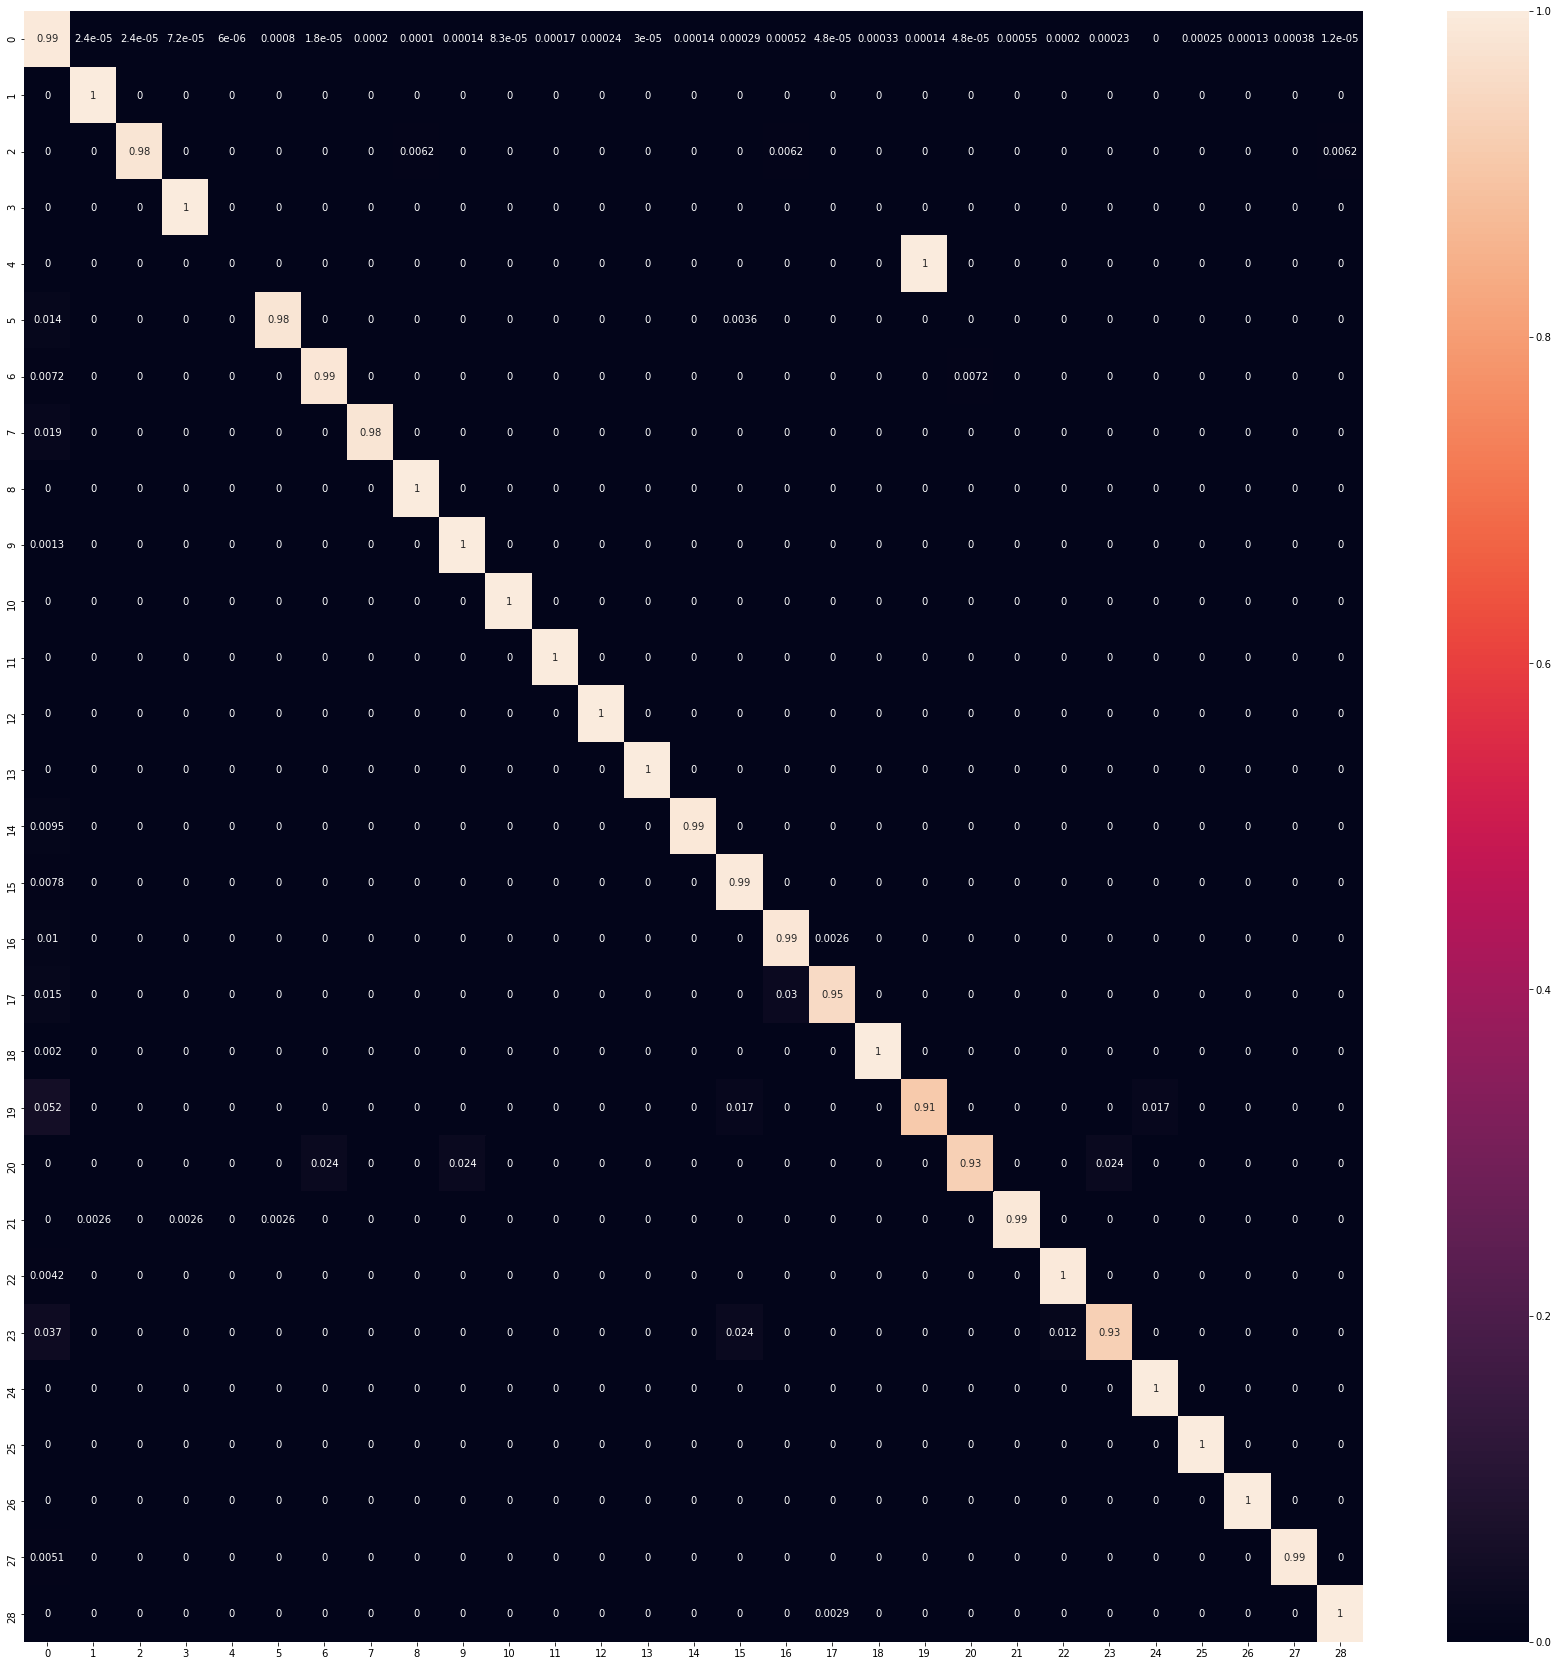

In [104]:
# test_data = text_dataset(extracted_text=all_comps.loc[12,'Text'],cluster_dict=cluster_dict,dataset_type='test')
# test_dl = DataLoader(test_data,batch_size=5,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
100%|███████████████████████████████████████████████████████████████████████████████| 454/454 [00:03<00:00, 116.57it/s]


{0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28}
23
{0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 16, 18, 20, 21, 22, 25, 26, 27, 28}
21
23
Kappa score : 0.41314716591094625



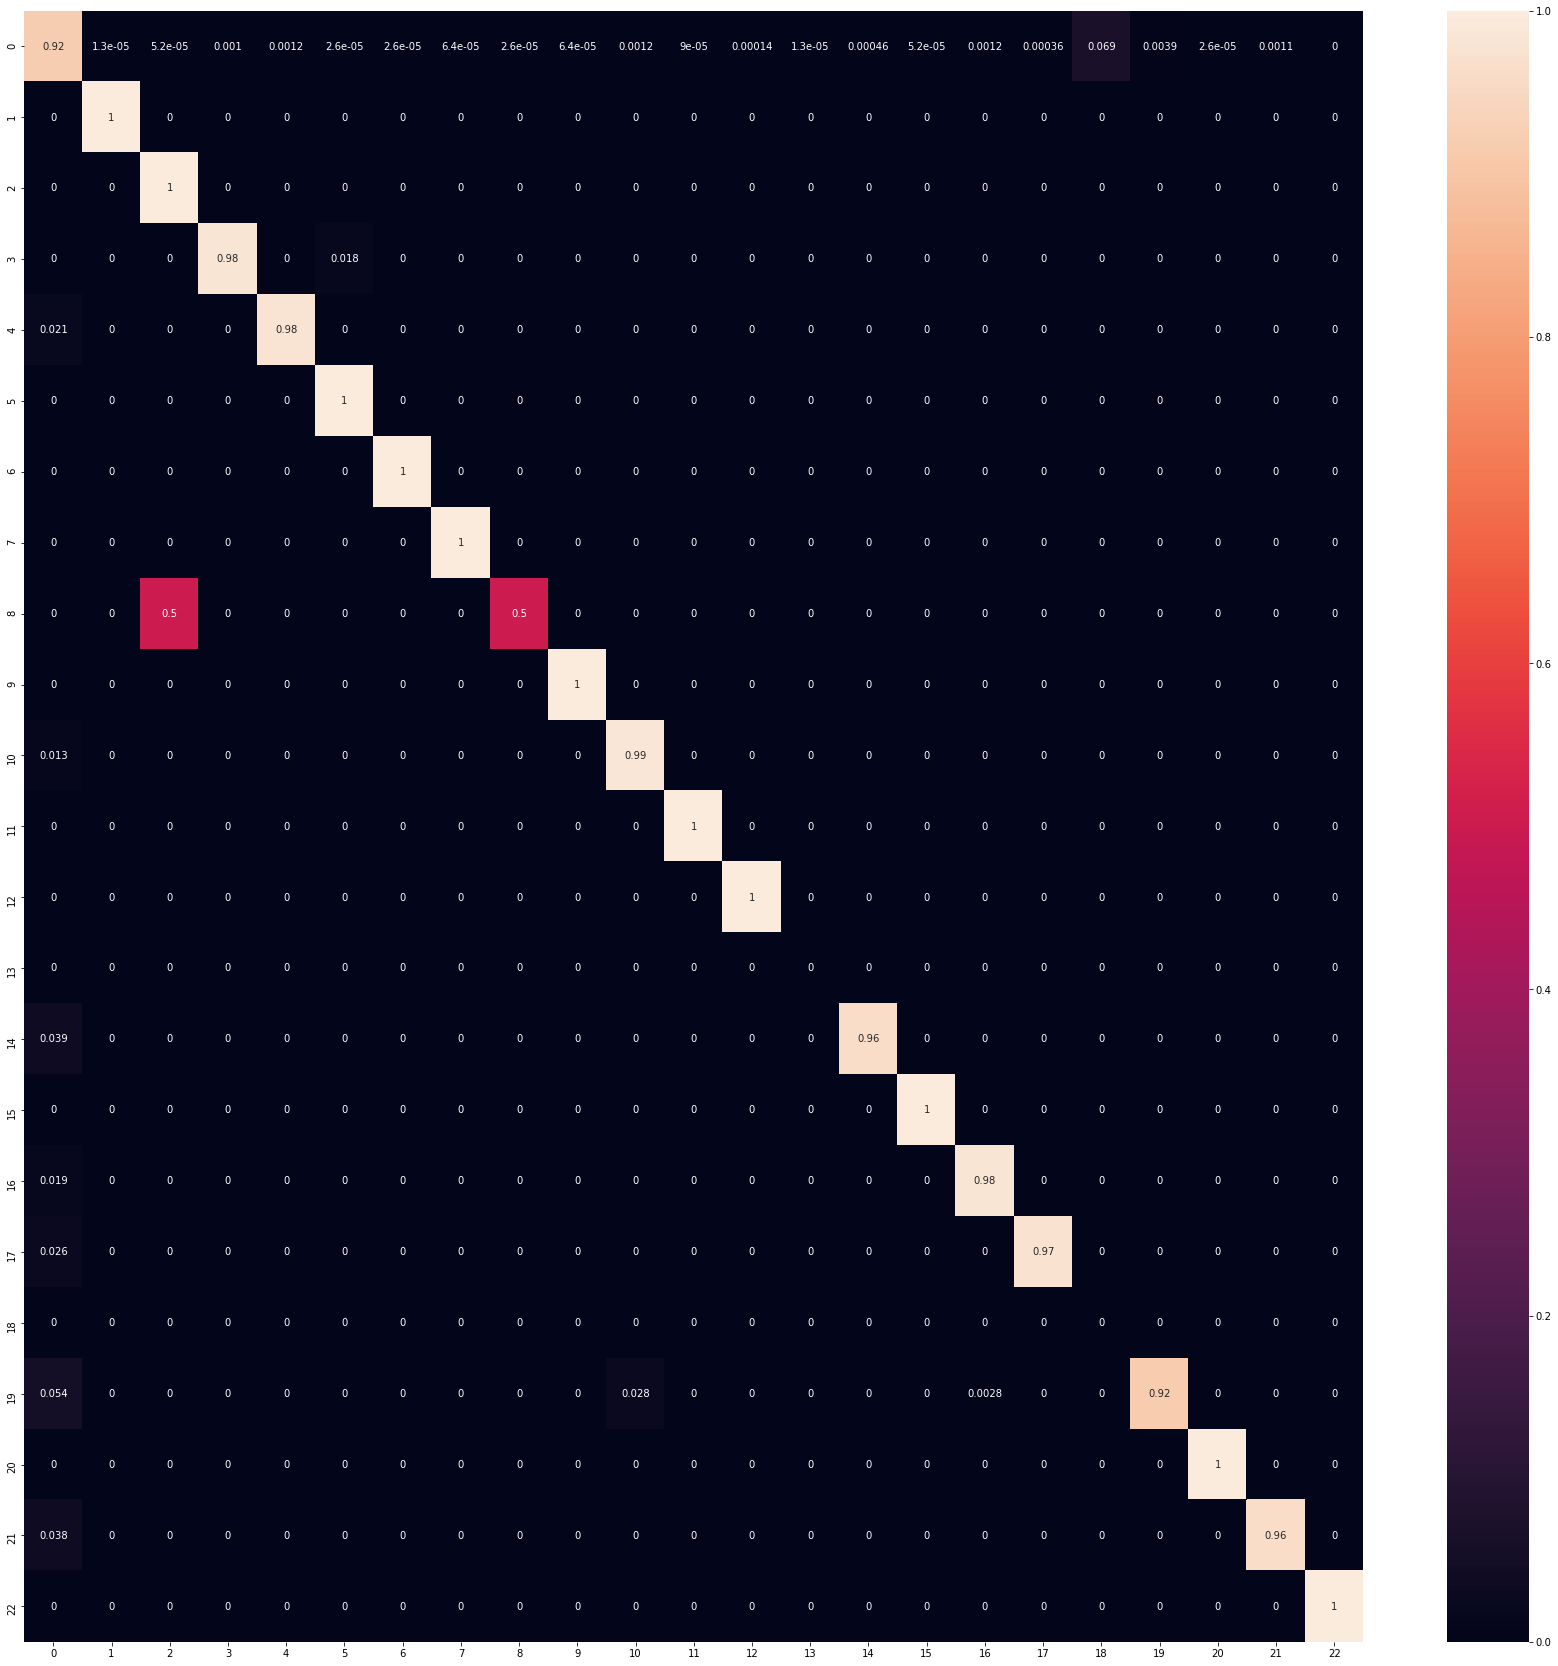

In [103]:
test_data = text_dataset(extracted_text=all_comps.loc[0,'Text'],cluster_dict=cluster_dict,dataset_type='test')
test_dl = DataLoader(test_data,batch_size=5,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(test_dl):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:03<00:00, 104.99it/s]


{0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28}
25
{0, 1, 2, 3, 5, 6, 7, 9, 11, 12, 14, 15, 16, 18, 20, 21, 22, 25, 26, 27, 28}
21
25
Kappa score : 0.36450753028984173



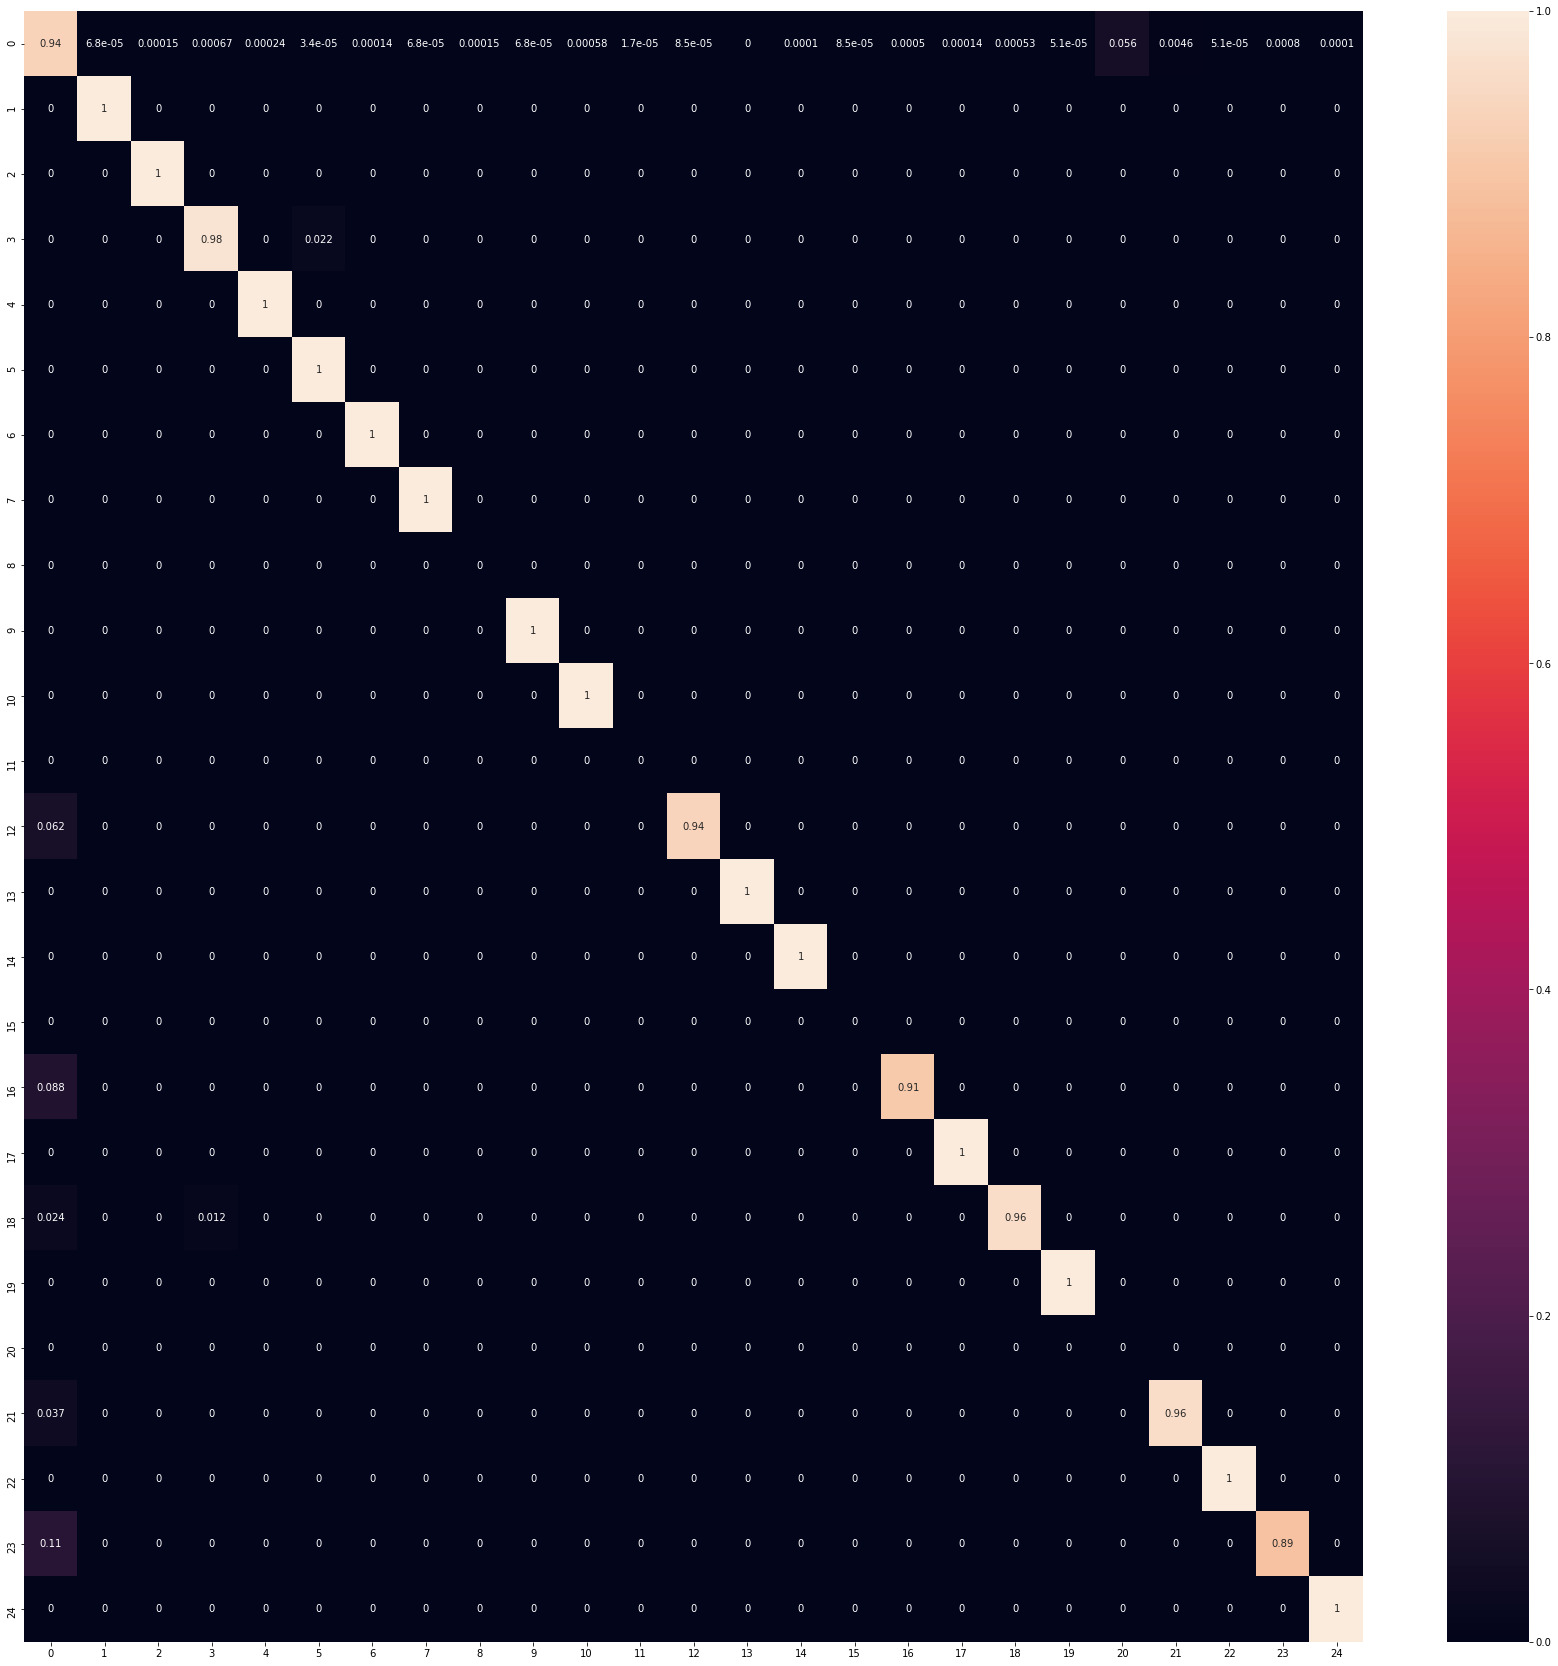

In [114]:
test_data = text_dataset(extracted_text=all_comps.loc[1,'Text'],cluster_dict=cluster_dict,dataset_type='test')
test_dl = DataLoader(test_data,batch_size=5,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(test_dl):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
100%|████████████████████████████████████████████████████████████████████████████████| 432/432 [00:04<00:00, 99.19it/s]


{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 25, 26, 27, 28}
25
{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 25, 26, 27, 28}
23
25
Kappa score : 0.33671856617096363



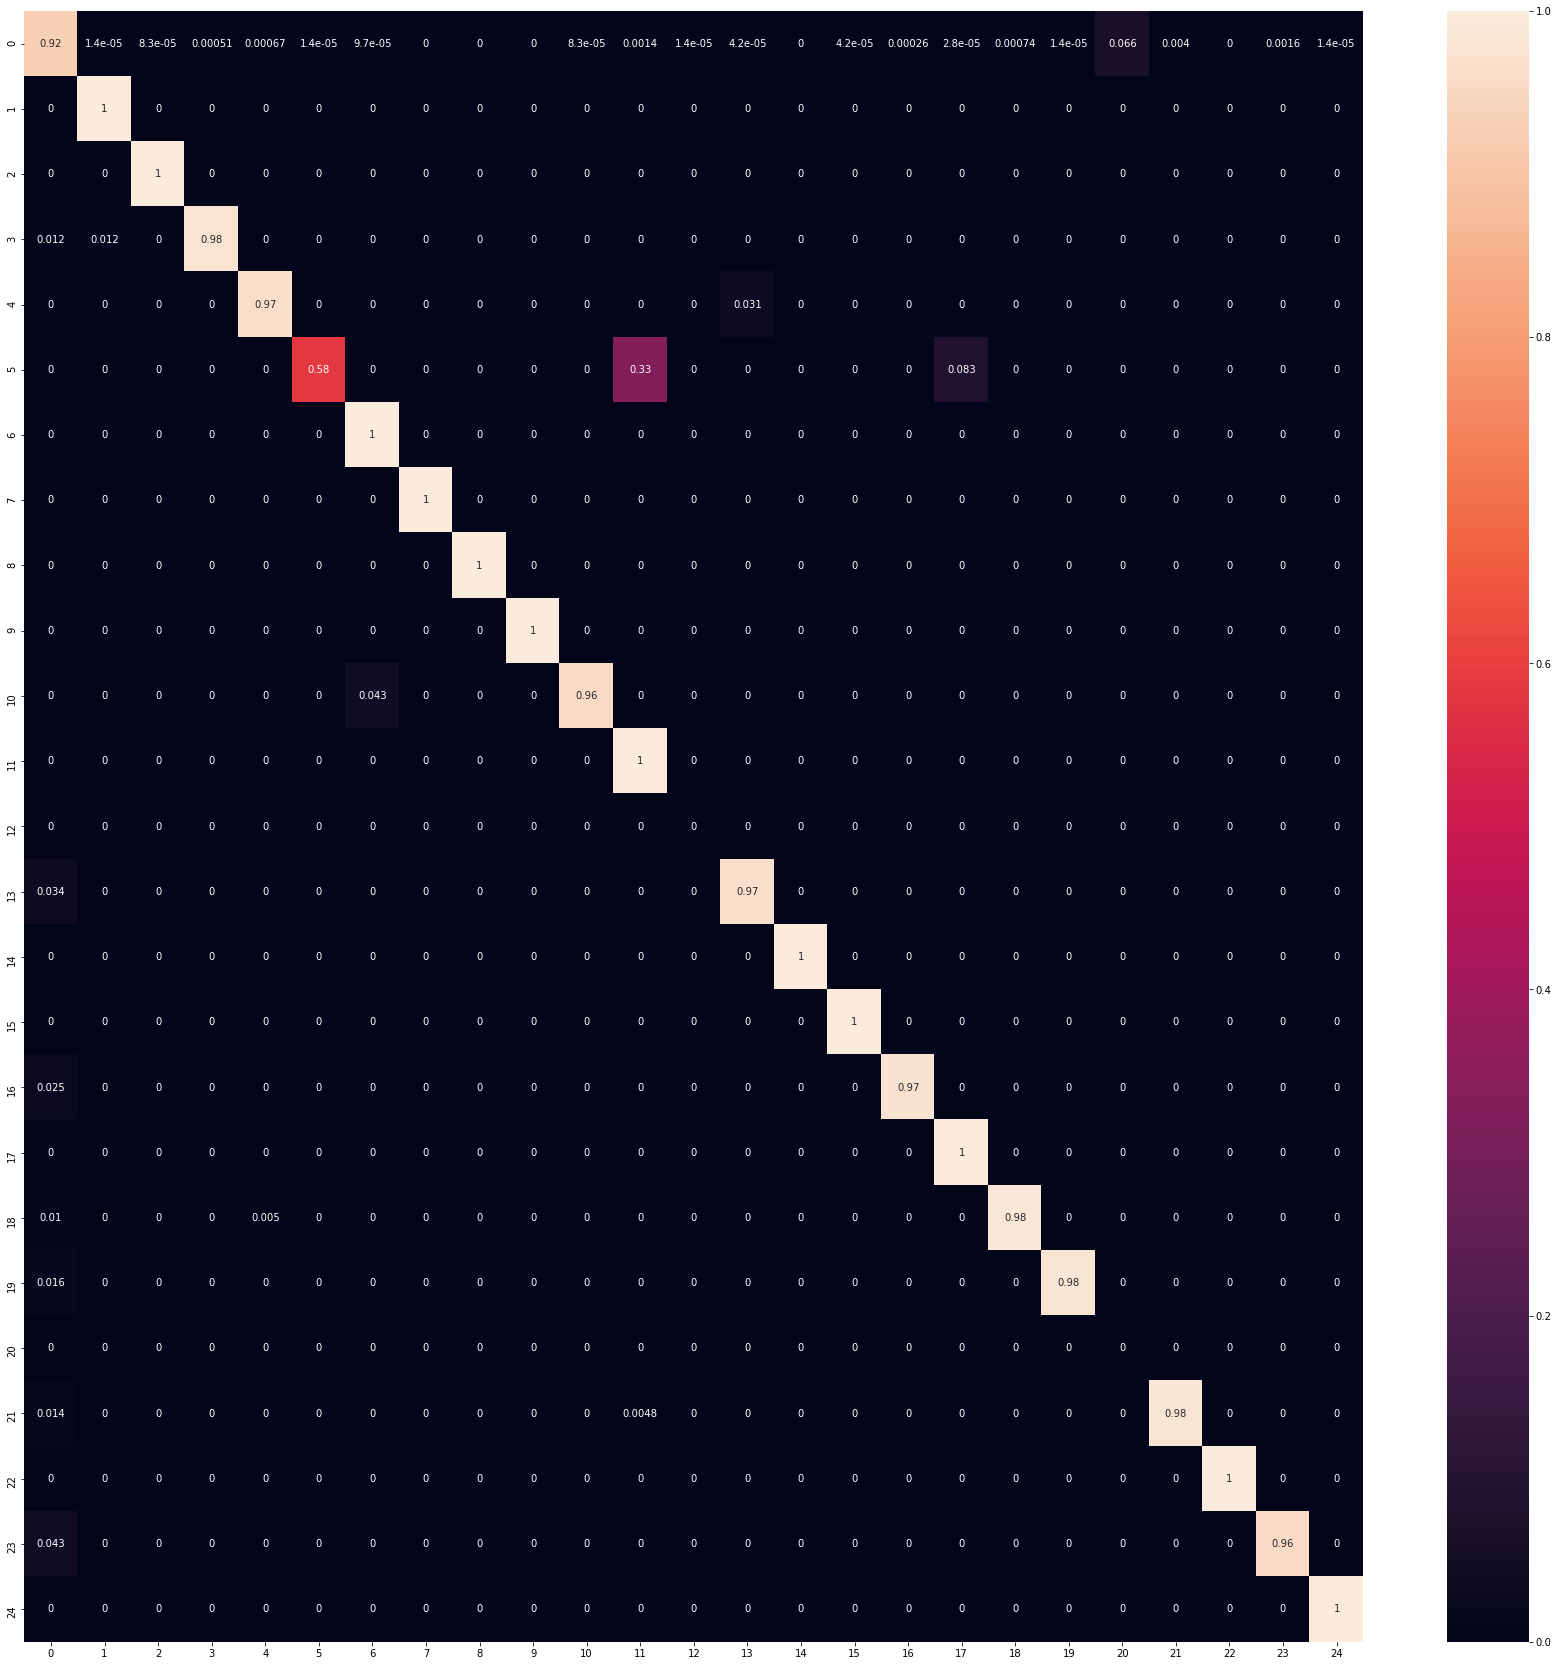

In [115]:
test_data = text_dataset(extracted_text=all_comps.loc[2,'Text'],cluster_dict=cluster_dict,dataset_type='test')
test_dl = DataLoader(test_data,batch_size=5,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(test_dl):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
100%|████████████████████████████████████████████████████████████████████████████████| 362/362 [00:03<00:00, 99.61it/s]


{0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28}
25
{0, 1, 2, 3, 5, 6, 7, 9, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 25, 26, 27, 28}
22
25
Kappa score : 0.3539229563497063



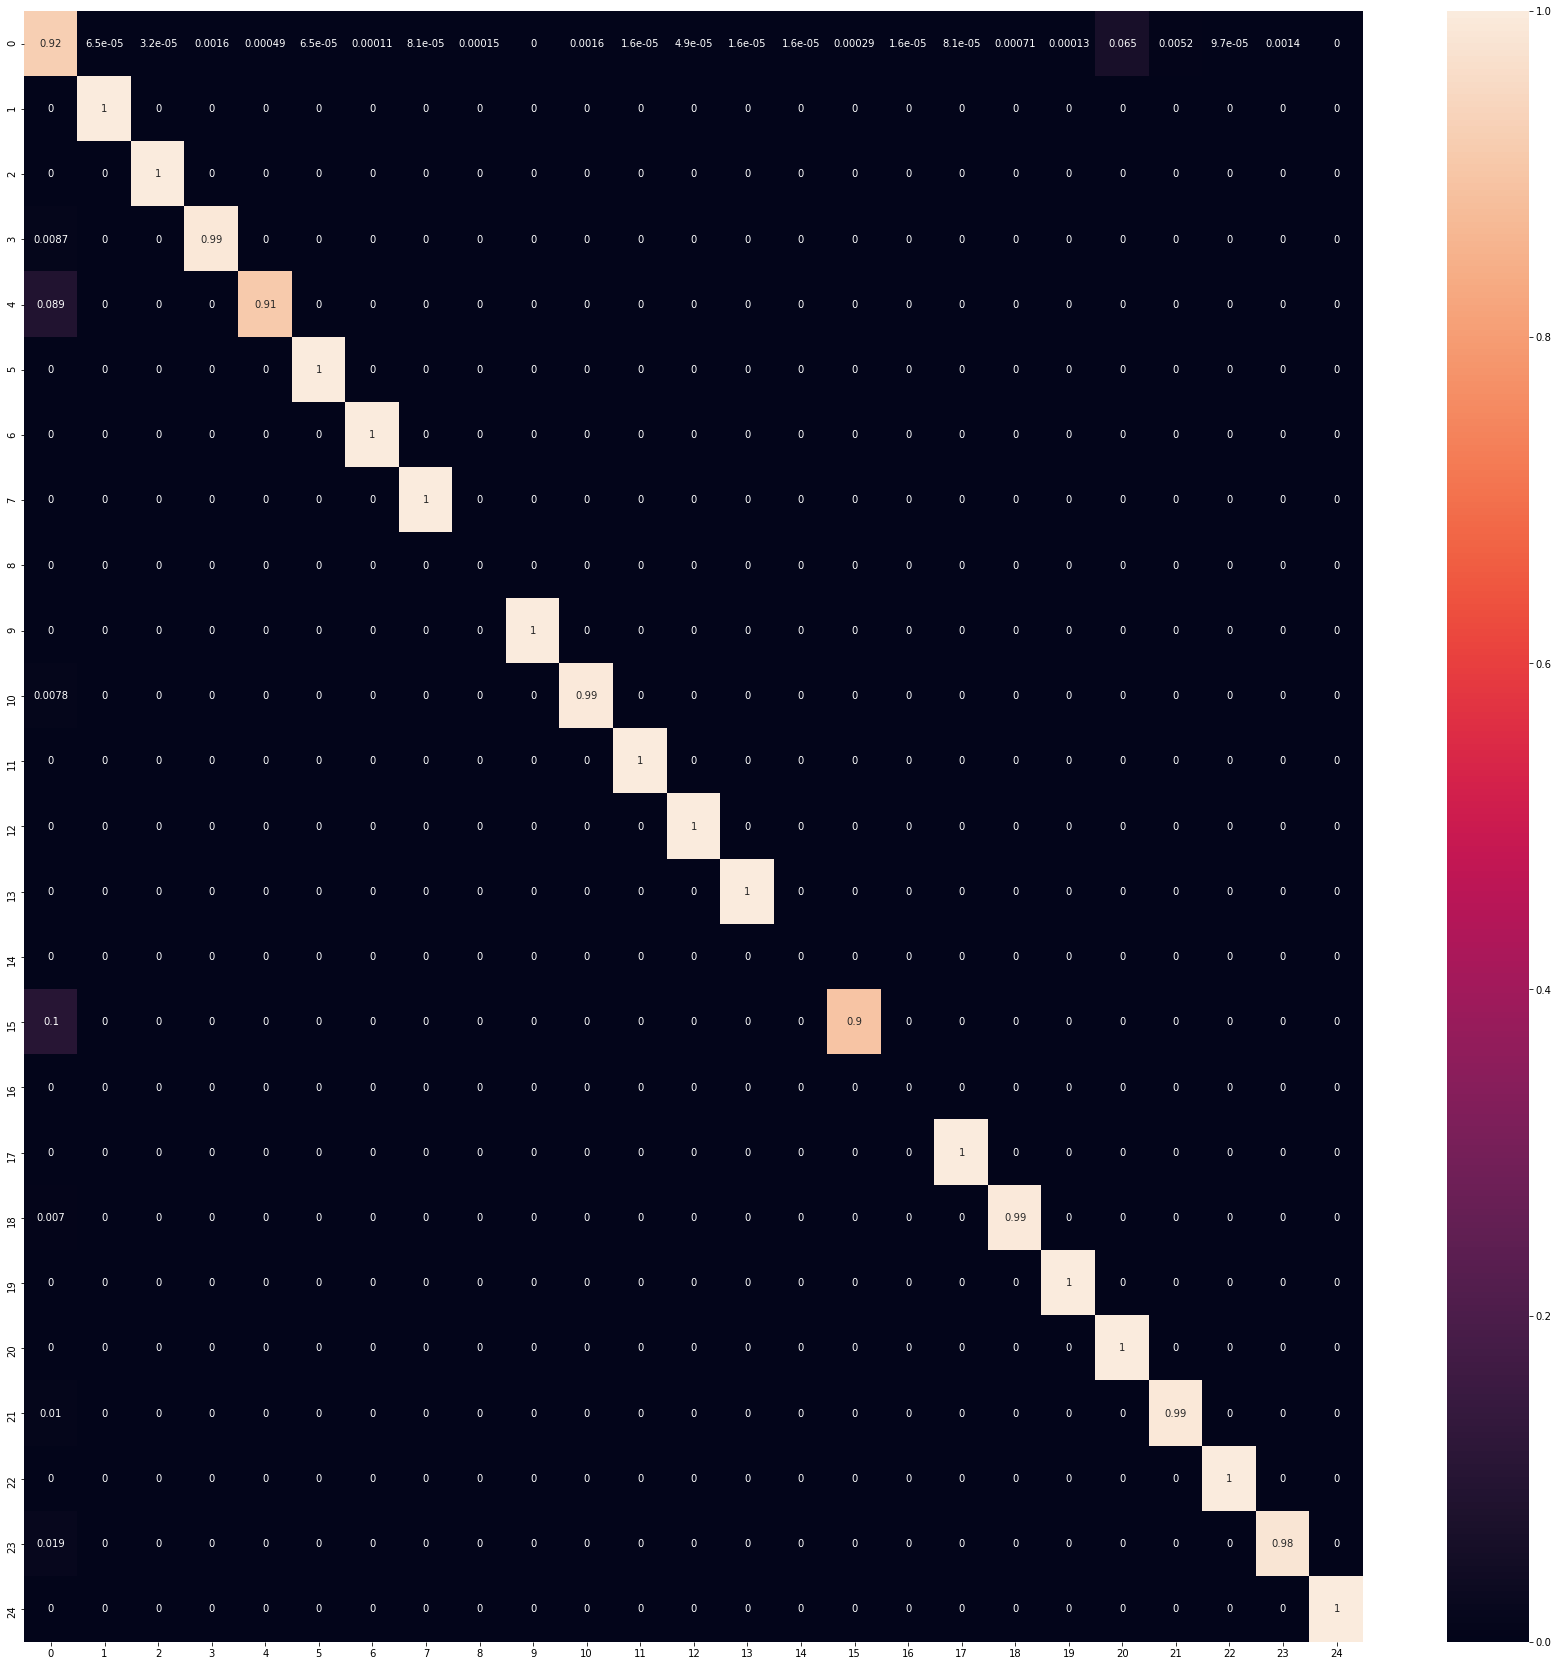

In [116]:
test_data = text_dataset(extracted_text=all_comps.loc[3,'Text'],cluster_dict=cluster_dict,dataset_type='test')
test_dl = DataLoader(test_data,batch_size=5,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(test_dl):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 75.04it/s]


{0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28}
24
{0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 18, 20, 21, 22, 25, 26, 27, 28}
21
24
Kappa score : 0.4556741758210997



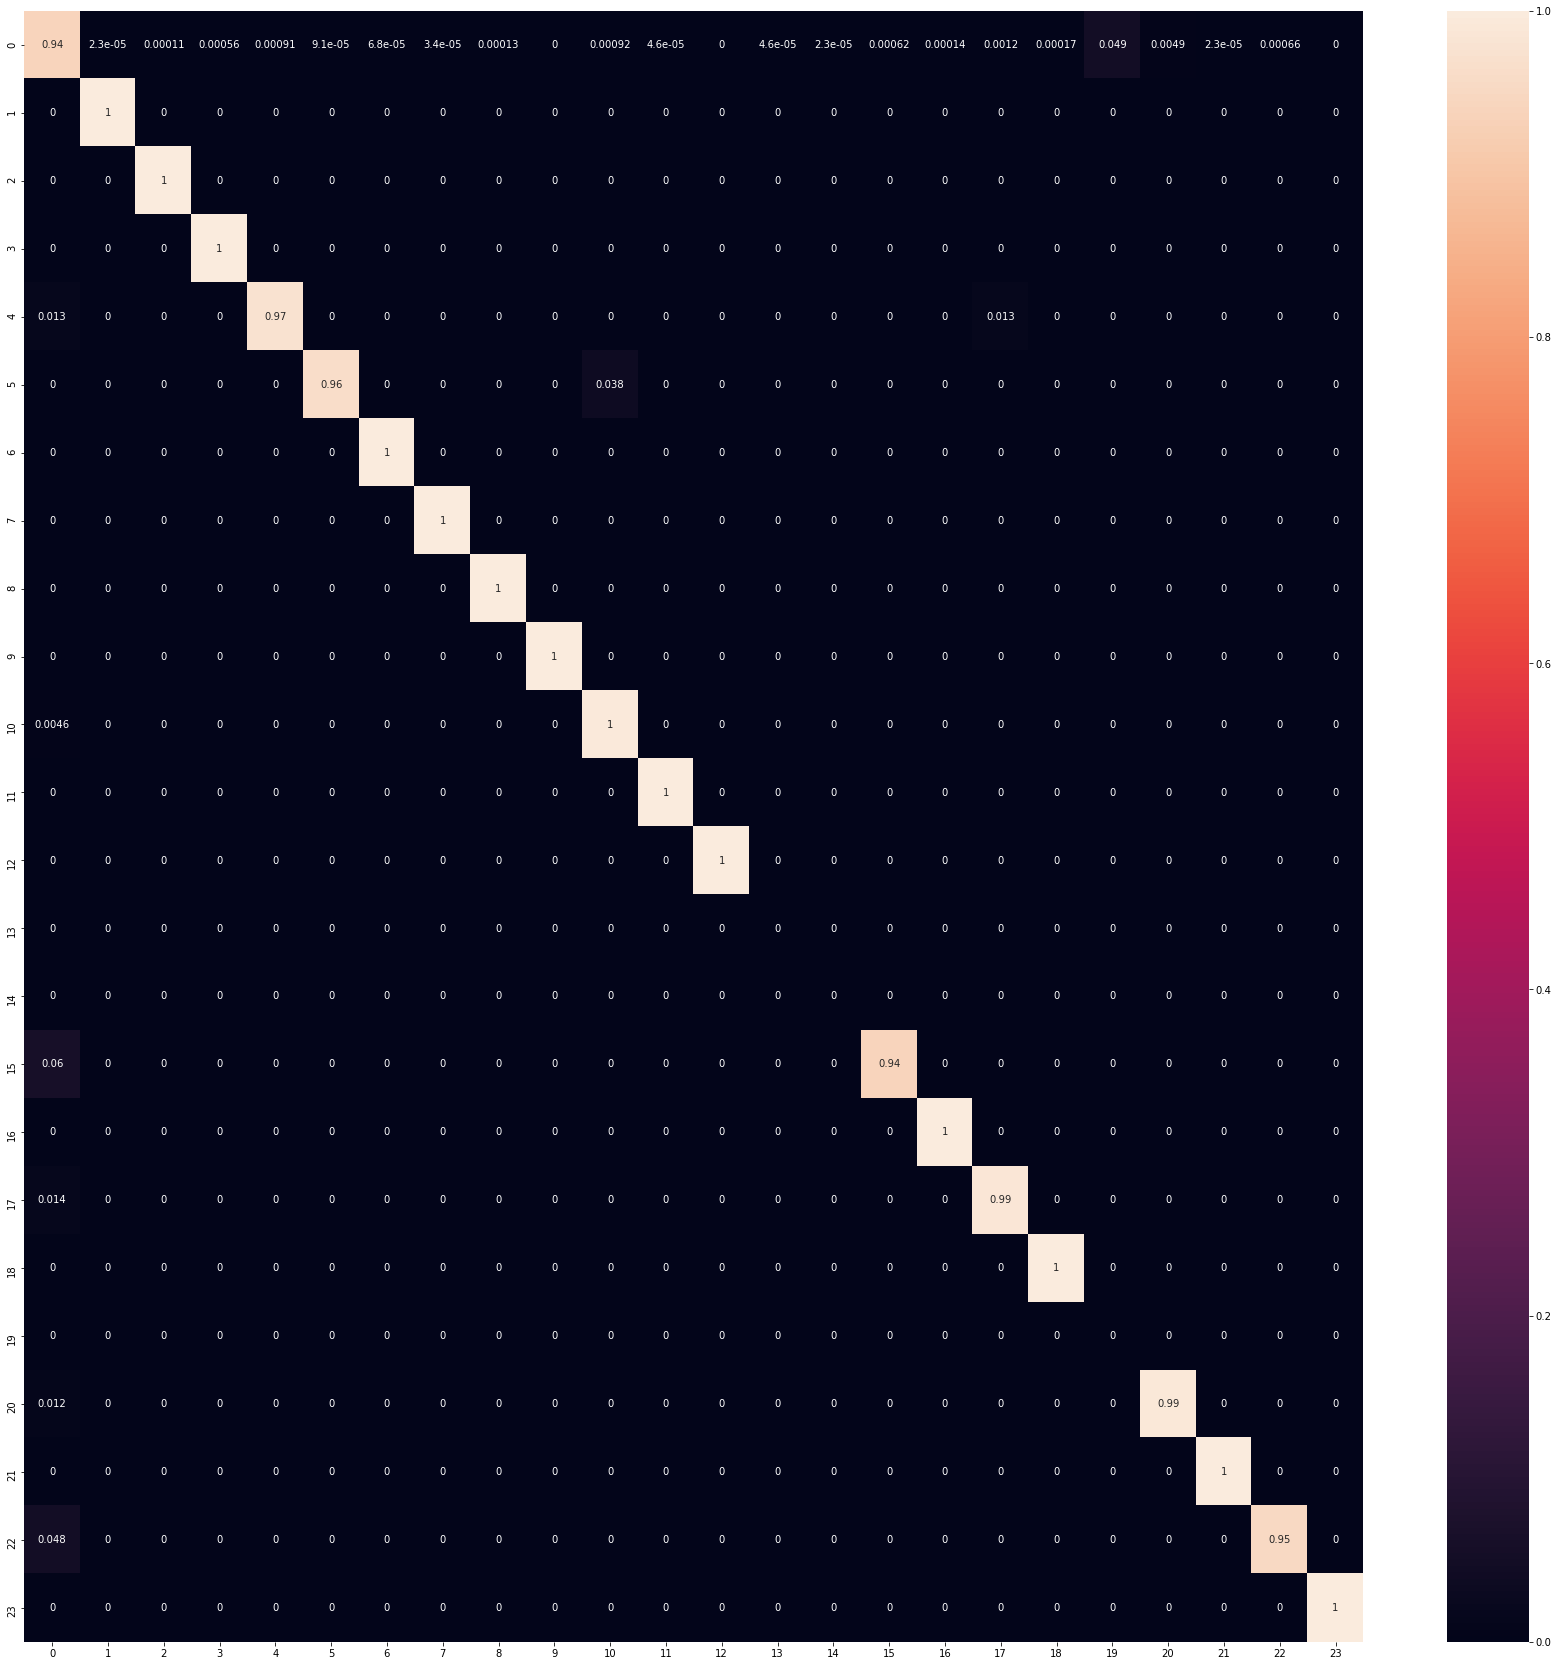

In [117]:
test_data = text_dataset(extracted_text=all_comps.loc[4,'Text'],cluster_dict=cluster_dict,dataset_type='test')
test_dl = DataLoader(test_data,batch_size=5,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(test_dl):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
100%|████████████████████████████████████████████████████████████████████████████████| 546/546 [00:06<00:00, 78.75it/s]


{0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28}
26
{0, 1, 2, 3, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 27, 28}
23
26
Kappa score : 0.4424147299376384



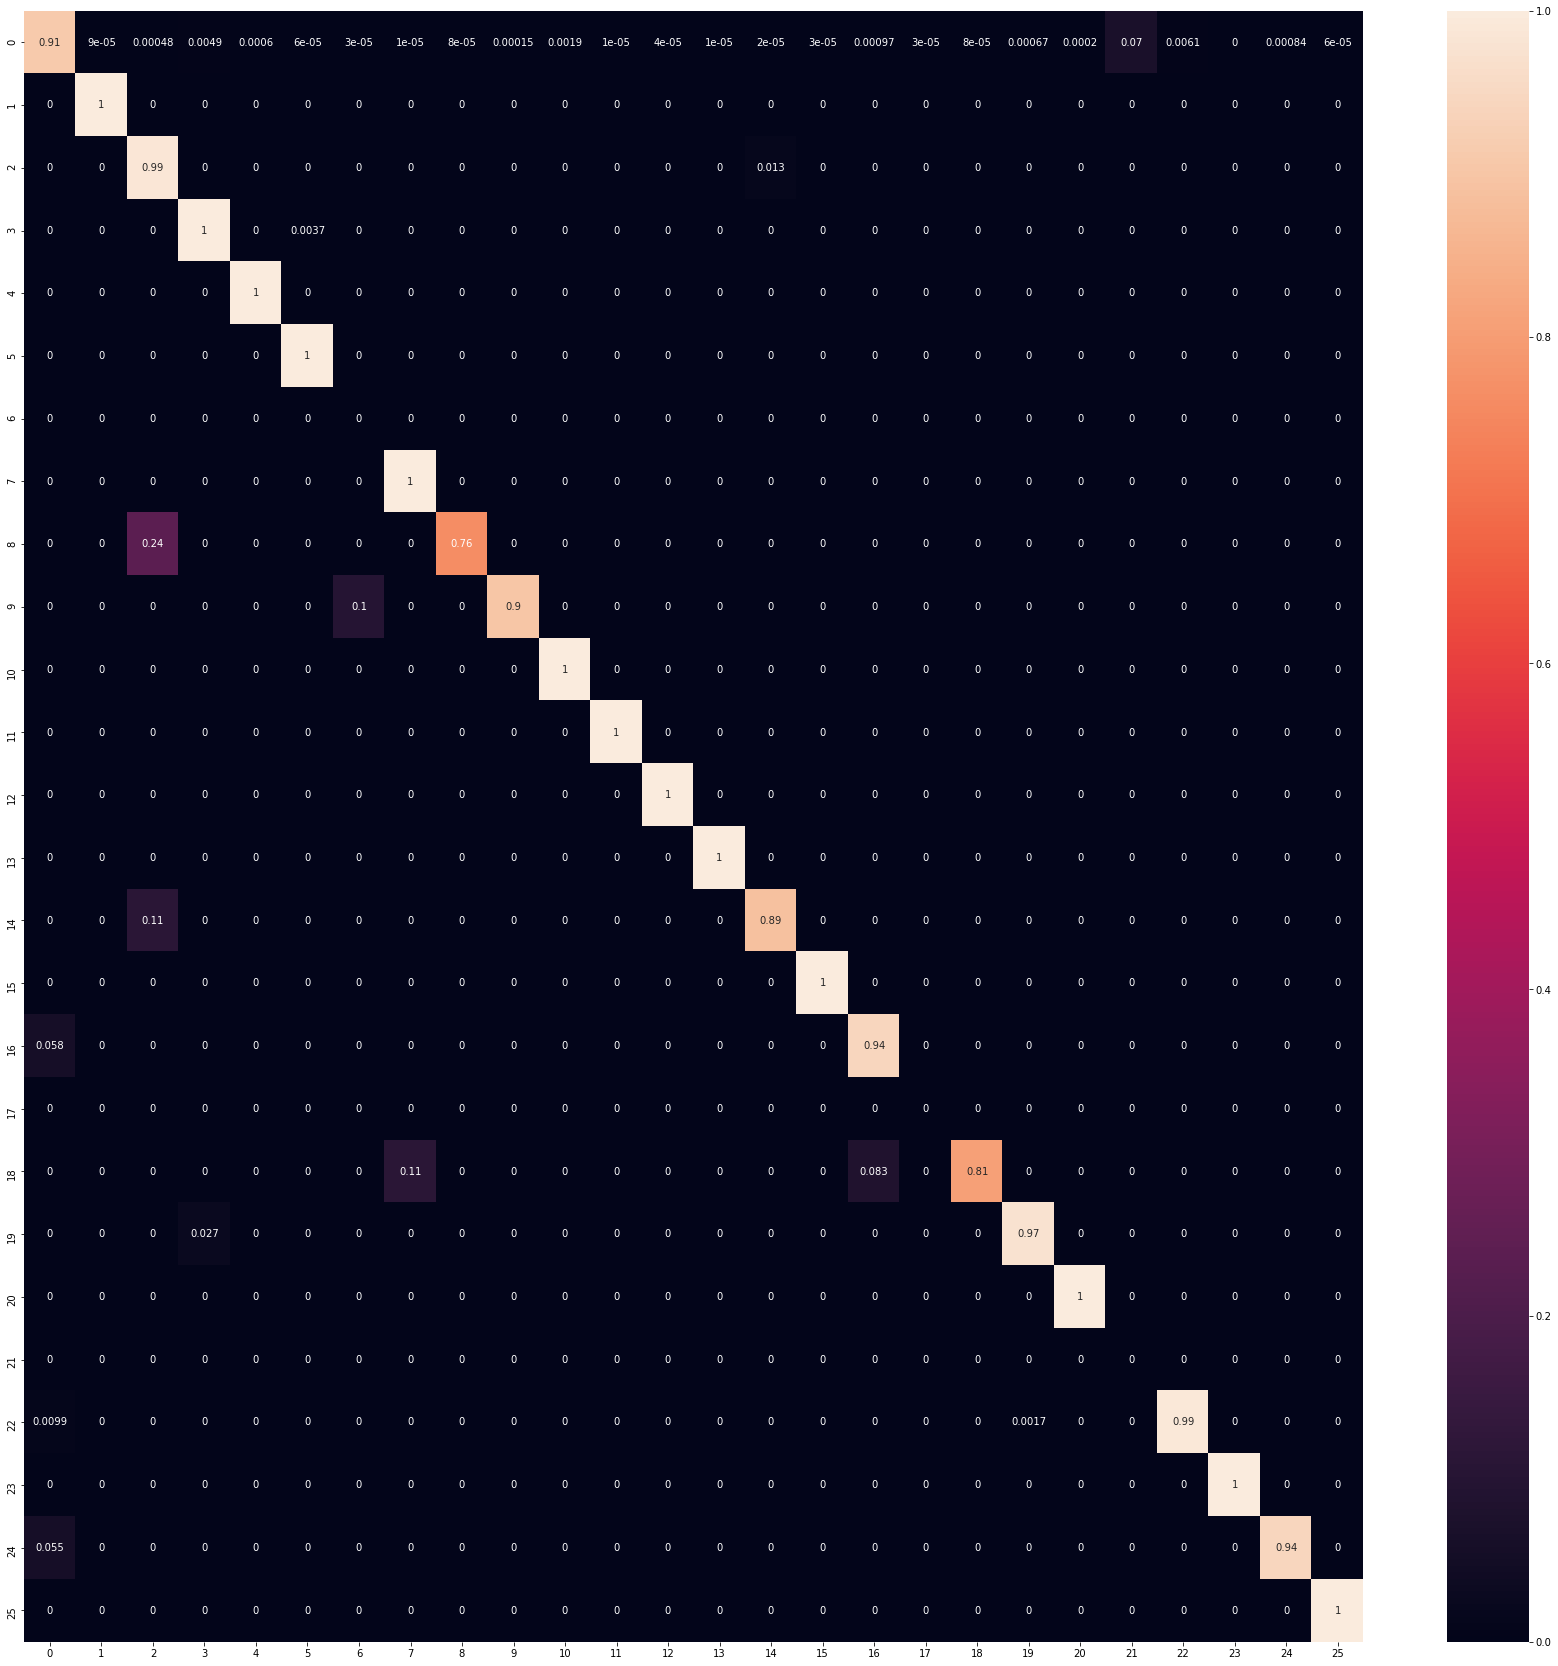

In [118]:
test_data = text_dataset(extracted_text=all_comps.loc[5,'Text'],cluster_dict=cluster_dict,dataset_type='test')
test_dl = DataLoader(test_data,batch_size=5,shuffle=False,collate_fn=model.collate_fn)

val_outs = []
val_targets = []
device = torch.device('cpu')
model = model.to(device)
for inputs,targets,sentence_lens in tqdm(test_dl):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).flatten()
        val_outs.append(preds)
        val_targets.append(targets.flatten())

print(set(torch.cat(val_outs).numpy()))
print(len(set(torch.cat(val_outs).numpy())))
print(set(torch.cat(val_targets).numpy()))
print(len(set(torch.cat(val_targets).numpy())))

consol_val_preds = torch.cat(val_outs)
consol_val_tgts = torch.cat(val_targets)
cm_idxs = max(len(set(consol_val_preds.numpy())),len(set(consol_val_tgts.numpy())))
print(cm_idxs)
kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
print(f'Kappa score : {kappa}\n')
cm = confusion_matrix(consol_val_tgts.cpu(),consol_val_preds.cpu(),normalize='true')
df_cm = pd.DataFrame(cm, index = [i for i in range(cm_idxs)],
                     columns = [i for i in range(cm_idxs)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

In [126]:
kappa_scores = []
for i in tqdm(range(len(all_comps))):
    test_data = text_dataset(extracted_text=all_comps.loc[i,'Text'],cluster_dict=cluster_dict,dataset_type='test')
    test_dl = DataLoader(test_data,batch_size=200,shuffle=False,collate_fn=model.collate_fn)
    val_outs = []
    val_targets = []
    device = torch.device('cpu')
    model = model.to(device)
    for inputs,targets,sentence_lens in test_dl:
        inputs = inputs.to(device)
        sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
        with torch.no_grad():
            outputs = model(inputs,sentence_lens)
            preds = torch.argmax(outputs,dim=1).flatten()
            val_outs.append(preds)
            val_targets.append(targets.flatten())
    consol_val_preds = torch.cat(val_outs)
    consol_val_tgts = torch.cat(val_targets)
    kappa = cohen_kappa_score(consol_val_preds,consol_val_tgts)
    kappa_scores.append(kappa)

  0%|                                                                                          | 0/463 [00:00<?, ?it/s]C:\Users\Owner\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
100%|████████████████████████████████████████████████████████████████████████████████| 463/463 [25:15<00:00,  3.27s/it]


In [127]:
print(sum(kappa_scores)/len(kappa_scores))

0.4230996372961605


In [128]:
least = [idx for idx in range(len(kappa_scores)) if kappa_scores[idx]<0.35]
least

[2,
 14,
 19,
 27,
 30,
 45,
 74,
 75,
 77,
 98,
 99,
 111,
 113,
 115,
 118,
 123,
 124,
 132,
 141,
 144,
 148,
 153,
 168,
 187,
 192,
 198,
 210,
 213,
 233,
 246,
 260,
 261,
 263,
 265,
 267,
 279,
 285,
 291,
 294,
 296,
 316,
 332,
 337,
 354,
 368,
 369,
 388,
 398,
 409,
 411,
 416,
 418,
 434,
 453,
 456,
 461]

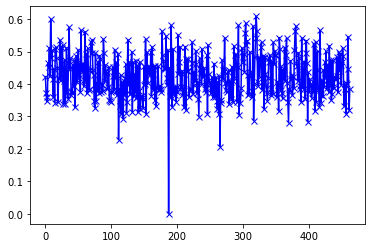

In [129]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(kappa_scores))),kappa_scores,'bx-')
plt.show()

In [123]:
all_comps.loc[2,'Text']

'10-K 1 a08-22004_110k.htm 10-K Table of Contents Exact name of registrant as specified in its charter Registrants telephone number, including area code 212-572-4200 None Indicate by check mark if the registrant is a well-known seasoned issuer, as defined in Rule 405 of the Securities Act.  Yes  x   No  o Indicate by check mark if the registrant is not required to file reports pursuant to Section 13 or Section 15d of the Act.  Yes  o   No  x Indicate by check mark whether the registrant 1 has filed all reports required to be filed by Section 13 or 15d of the Securities Exchange Act of 1934 during the preceding 12 months or for such shorter period that the registrant was required to file such reports, and 2 has been subject to such filing requirements for the past 90 days.  Yes  x   No  o Indicate by check mark if disclosure of delinquent filers pursuant to Item 405 of Regulation S-K is not contained herein, and will not be contained, to the best of registrants knowledge, in definitive 

In [530]:
fval_words = []
fval_preds = []
for inputs,targets,sentence_lens in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    sentence_lens = torch.tensor(sentence_lens,dtype=torch.long,device=device)
    with torch.no_grad():
        outputs = model(inputs,sentence_lens)
        preds = torch.argmax(outputs,dim=1).permute(1,0)
        words = inputs.flatten()
        word_preds = preds.flatten()
        for i in range(words.size()[0]):
            if words[i].item() != 0:
                fval_words.append(train_data.vocabulary.idx2word[words[i].item()])
                fval_preds.append(word_preds[i].item())

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:26<00:00,  1.68it/s]


In [533]:
cluster_preds = {}
for i in range(29):
    cluster_preds[i]=[]
for word,pred in zip(fval_words,fval_preds):
    cluster_preds[pred].append(word)
for i in range(29):
    cluster_preds[i]=list(set(cluster_preds[i]))

In [541]:
file1 = open('first_run_preds.pkl','wb')
pickle.dump(cluster_preds,file1)
file1.close()
file2 = open('first_run_og.pkl','wb')
pickle.dump(cluster_dict,file2)
file2.close()

In [559]:
x = 16
print(cluster_preds[x])
print(cluster_dict[x])

['wgi', 'biotic', 'hypoxemia', 'stee', 'whe', 'lampitt', 'calcify', 'lakebeds', 'milly', 'illustrative', 'arr', 'rng', 'chroniclers', 'seasonality', 'situ', 'plagues', 'multiscale', 'ellie', 'ottmar', 'cloudier', 'pauline', 'wm', 'avoidable', 'sérgio', 'homeostatic', 'dx', 'stimulatory', 'inversely', 'cdr', 'bathypelagic', 'cece', 'troposphere', 'berkes', 'chem', 'exacerbation', 'breakpoints', 'modulations', 'poleward', 'ei', 'continuations', 'attributional', 'neutralization', 'localized', 'hsd', 'priori', 'scaler', 'eal', 'concessional', 'gnv', 'disrupts', 'timescale', 'huxleyi', 'insolation', 'raper', 'photosystem', 'borehole', 'susanne', 'regulary', 'nuttall', 'typologies', 'constrains', 'overestimation', 'limacina', 'skiba', 'hore', 'gf', 'nonlinear', 'baselines', 'phenology', 'upwelling', 'tor', 'sio', 'thickening', 'hwp', 'urbanization', 'vv', 'reto', 'renner', 'wanninkhof', 'lemelin', 'modifies', 'gridded', 'biophysical', 'timescales', 'arbuscula', 'porites', 'depletions', 'thre